<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/TCN_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 37.0 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 210 kB 54.5 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 147 kB 77.9 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 68.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=02301dbc78f9666d8235390031809e1404068fba72994e423f0f795ef671ca5b
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unin

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#libraries for a TCN structure
from torch.nn.utils import weight_norm
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [3]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [4]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [5]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [6]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [7]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [8]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [9]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [11]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [12]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [14]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [15]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

TCN structure (code is based on the TSAI library)


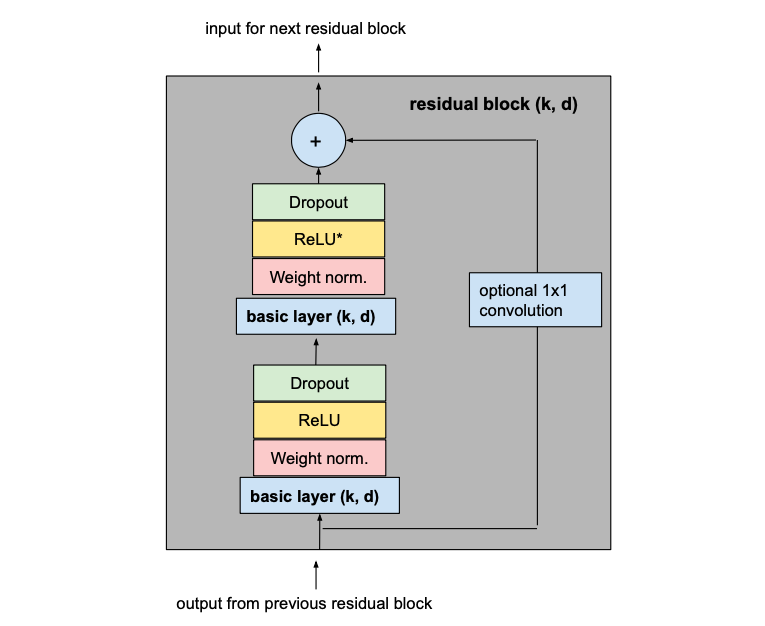

In [24]:
#making a residual block
class TemporalBlock(Module):
    def __init__(self, ni, nf, ks, stride, dilation, padding, dropout=0.):

        #the first step #torch.nn.utils.weight_norm()
        self.conv1 = nn.Conv1d(ni,nf,ks,stride=stride,padding=padding,dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        #the second step
        self.conv2 = nn.Conv1d(nf,nf,ks,stride=stride,padding=padding,dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        #make the sequential series
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, 
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        #the parallel stream
        self.downsample = nn.Conv1d(ni,nf,1) if ni != nf else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None: self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

building the sequence

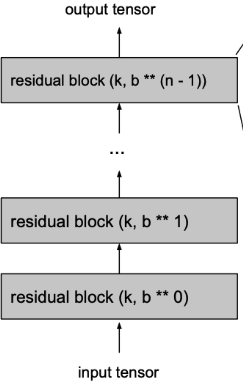

In [25]:
def TemporalConvNet(c_in, layers, ks=2, dropout=0.):
    temp_layers = []
    for i in range(len(layers)):
        dilation_size = 2 ** i
        ni = c_in if i == 0 else layers[i-1]
        nf = layers[i]
        temp_layers += [TemporalBlock(ni, nf, ks, stride=1, dilation=dilation_size, padding=(ks-1) * dilation_size, dropout=dropout)]
    return nn.Sequential(*temp_layers)

build the final model

In [26]:
class TCN(Module):
    def __init__(self, c_in, c_out, layers=4*[16], ks=4, conv_dropout=0., fc_dropout=0.):
        #parameters guide: c_in = input dimension, c_out = output dimension, layers = number and size of the layer for residual blocks, ks = kernel size(TCN kernel)
        
        self.tcn = TemporalConvNet(c_in, layers, ks=ks, dropout=conv_dropout)
        self.gap = GAP1d()
        self.dropout = nn.Dropout(fc_dropout) if fc_dropout else None
        self.linear = nn.Linear(layers[-1],c_out)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tcn(x)
        x = self.gap(x)
        if self.dropout is not None: x = self.dropout(x)
        return self.linear(x)

In [27]:
#checking dimensions of the GRU layers
#x = torch.rand(64, 120, 9)
#model = TCN(c_in = 9, 
#            layers=4*[16],
#            ks=3,
#            c_out=24)

#y = model(x)
#y.shape

In [28]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    L_size = trial.suggest_int("hidden_layer", 16, 64)
    # Generate the model.
    model = TCN(c_in = 9, 
            layers=4*[L_size],
            ks=trial.suggest_int("TCN_kernel_size", 2, 5),
            c_out=24).cuda()
            #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "TCN_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [29]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-24 16:37:55,573] A new study created in memory with name: no-name-65b4897e-1f4a-413b-95b0-9cde9188514f


Iter:  0 train:  1515.89621925354 val:  228.5707243680954
Iter:  20 train:  213.07916203141212 val:  57.34406843036413
Iter:  40 train:  149.19209069013596 val:  43.70295184850693
Iter:  60 train:  127.54627712070942 val:  39.5730712749064
Iter:  80 train:  118.39265094697475 val:  38.872091084718704
Iter:  100 train:  110.86114325374365 val:  38.07185326144099
Iter:  120 train:  105.40833811461926 val:  36.74567446485162
Iter:  140 train:  102.27873563021421 val:  35.144886726513505
Iter:  160 train:  97.87126437574625 val:  34.44960551708937
Iter:  180 train:  94.48328877985477 val:  39.663427436724305
Iter:  200 train:  91.50457587838173 val:  32.60228041373193
Iter:  220 train:  88.86482854187489 val:  32.21835818141699


[I 2022-12-24 16:57:28,843] Trial 0 finished with value: 31.997628374025226 and parameters: {'hidden_layer': 34, 'TCN_kernel_size': 4, 'lr': 9.060164828318441e-05}. Best is trial 0 with value: 31.997628374025226.


Iter:  0 train:  1126.8178561925888 val:  217.33288368582726
Iter:  20 train:  159.20768308639526 val:  45.68032343685627
Iter:  40 train:  104.39715061336756 val:  35.09920810163021
Iter:  60 train:  91.00083299726248 val:  32.66582500189543
Iter:  80 train:  81.5545137450099 val:  29.295855052769184
Iter:  100 train:  76.40729812532663 val:  29.848652163520455
Iter:  120 train:  71.1516864001751 val:  29.089588528499007


[I 2022-12-24 17:08:09,261] Trial 1 finished with value: 28.036545768380165 and parameters: {'hidden_layer': 41, 'TCN_kernel_size': 4, 'lr': 0.00021186141797185755}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  994.9169542789459 val:  207.17841374874115
Iter:  20 train:  117.66980212926865 val:  39.06442974507809
Iter:  40 train:  94.60098164528608 val:  36.79902345314622
Iter:  60 train:  81.14044519513845 val:  34.511392537504435
Iter:  80 train:  69.73997983336449 val:  33.33315047994256
Iter:  100 train:  60.63894386589527 val:  32.35124172642827
Iter:  120 train:  55.78256496787071 val:  31.08152092061937


[I 2022-12-24 17:18:55,186] Trial 2 finished with value: 29.421845505014062 and parameters: {'hidden_layer': 28, 'TCN_kernel_size': 4, 'lr': 0.0005713581426821145}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  2420.3613280057907 val:  239.57947897911072
Iter:  20 train:  703.6583721041679 val:  190.64194509387016
Iter:  40 train:  276.6506334543228 val:  74.5188440978527
Iter:  60 train:  214.49808910489082 val:  60.46237628906965
Iter:  80 train:  193.1215312629938 val:  54.62593241035938
Iter:  100 train:  175.83044889569283 val:  48.52086789906025
Iter:  120 train:  158.9471404403448 val:  45.1642187461257
Iter:  140 train:  145.58016516268253 val:  42.00892462581396
Iter:  160 train:  136.2973357439041 val:  40.23250365257263
Iter:  180 train:  128.9511593580246 val:  39.32787197083235
Iter:  200 train:  123.32115833461285 val:  38.70583109930158
Iter:  220 train:  120.07851845026016 val:  41.81003800779581
Iter:  240 train:  116.73141707479954 val:  36.80590460635722


[I 2022-12-24 17:39:48,744] Trial 3 finished with value: 35.8492643982172 and parameters: {'hidden_layer': 48, 'TCN_kernel_size': 3, 'lr': 2.755064508539582e-05}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  1272.2250164747238 val:  226.30961483716965
Iter:  20 train:  256.9965770840645 val:  78.60576368868351
Iter:  40 train:  202.52283154428005 val:  61.84090901911259
Iter:  60 train:  171.0850955694914 val:  51.80681141465902
Iter:  80 train:  148.6993359476328 val:  47.4139115139842
Iter:  100 train:  137.22698402404785 val:  46.478021301329136
Iter:  120 train:  127.14051026105881 val:  42.73190264776349
Iter:  140 train:  119.70606894046068 val:  39.009227469563484
Iter:  160 train:  115.31038518249989 val:  38.60402585566044
Iter:  180 train:  110.13746797293425 val:  36.14869314804673
Iter:  200 train:  106.08023808151484 val:  34.752489019185305
Iter:  220 train:  101.35677178949118 val:  34.97341858968139
Iter:  240 train:  98.28402362763882 val:  33.61503617465496


[I 2022-12-24 17:59:58,435] Trial 4 finished with value: 33.43620356544852 and parameters: {'hidden_layer': 35, 'TCN_kernel_size': 2, 'lr': 0.0001908688230236766}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  1181.902742266655 val:  221.22372579574585
Iter:  20 train:  159.5185715407133 val:  48.69806494563818
Iter:  40 train:  118.21461267769337 val:  37.22046237438917
Iter:  60 train:  102.31675728410482 val:  35.17068347707391
Iter:  80 train:  90.88927886635065 val:  33.37152876518667
Iter:  100 train:  83.55278449505568 val:  30.460091246291995
Iter:  120 train:  78.16112946718931 val:  29.902722500264645
Iter:  140 train:  73.62761695683002 val:  32.031209386885166
Iter:  160 train:  69.47578436136246 val:  29.313732642680407
Iter:  180 train:  66.35348469018936 val:  29.970788966864347


[I 2022-12-24 18:15:57,001] Trial 5 finished with value: 28.855040322989225 and parameters: {'hidden_layer': 45, 'TCN_kernel_size': 3, 'lr': 0.00018227586769176306}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  1350.2620455026627 val:  230.2824831008911


[I 2022-12-24 18:16:31,478] Trial 6 pruned. 


Iter:  0 train:  1200.0244866609573 val:  217.25553691387177


[I 2022-12-24 18:17:06,594] Trial 7 pruned. 


Iter:  0 train:  1141.7501729726791 val:  227.82521349191666


[I 2022-12-24 18:17:42,716] Trial 8 pruned. 


Iter:  0 train:  1578.728535413742 val:  229.98788571357727


[I 2022-12-24 18:18:23,346] Trial 9 pruned. 


Iter:  0 train:  6398.391893386841 val:  1514.616542816162


[I 2022-12-24 18:18:55,205] Trial 10 pruned. 


Iter:  0 train:  915.3629994392395 val:  217.26166352629662
Iter:  20 train:  93.87026666849852 val:  37.829039577394724
Iter:  40 train:  68.4363174252212 val:  30.36941589228809
Iter:  60 train:  51.289717718958855 val:  32.44875459000468


[I 2022-12-24 18:24:15,463] Trial 11 finished with value: 30.267648700624704 and parameters: {'hidden_layer': 47, 'TCN_kernel_size': 3, 'lr': 0.0007397318646993737}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  968.651823759079 val:  212.3838574886322
Iter:  20 train:  113.60144508630037 val:  37.010294798761606
Iter:  40 train:  86.51741995662451 val:  32.19998865574598
Iter:  60 train:  73.89147388935089 val:  30.080667175352573
Iter:  80 train:  63.92261027544737 val:  31.20376131683588


[I 2022-12-24 18:31:22,551] Trial 12 finished with value: 29.469833036884665 and parameters: {'hidden_layer': 46, 'TCN_kernel_size': 3, 'lr': 0.0004317142363716912}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  1499.8088895082474 val:  232.1654868721962


[I 2022-12-24 18:31:58,605] Trial 13 pruned. 


Iter:  0 train:  1085.9878811836243 val:  214.36040922999382


[I 2022-12-24 18:32:34,910] Trial 14 pruned. 


Iter:  0 train:  1189.359957933426 val:  220.0702222287655
Iter:  20 train:  135.22812665998936 val:  44.787252727895975


[I 2022-12-24 18:35:07,676] Trial 15 pruned. 


Iter:  0 train:  853.0465457439423 val:  201.3534116744995
Iter:  20 train:  57.85570763796568 val:  35.22316186502576


[I 2022-12-24 18:38:15,654] Trial 16 finished with value: 31.571424417197704 and parameters: {'hidden_layer': 64, 'TCN_kernel_size': 4, 'lr': 0.0008564994310412007}. Best is trial 1 with value: 28.036545768380165.


Iter:  0 train:  1020.7725300788879 val:  210.24813917279243
Iter:  20 train:  126.04961910843849 val:  38.28649663925171
Iter:  40 train:  101.46665064245462 val:  33.11876515485346
Iter:  60 train:  85.62436177581549 val:  29.2329863011837
Iter:  80 train:  78.51021806895733 val:  29.334294486790895
Iter:  100 train:  71.00115715712309 val:  29.450223119929433
Iter:  120 train:  65.96139664947987 val:  28.595778161659837


[I 2022-12-24 18:48:34,005] Trial 17 finished with value: 27.57906417362392 and parameters: {'hidden_layer': 40, 'TCN_kernel_size': 3, 'lr': 0.000328631502996764}. Best is trial 17 with value: 27.57906417362392.


Iter:  0 train:  1067.0928919911385 val:  209.16029873490334
Iter:  20 train:  125.24389190971851 val:  42.280702996999025


[I 2022-12-24 18:50:49,530] Trial 18 pruned. 


Iter:  0 train:  1400.6228526830673 val:  234.60908377170563


[I 2022-12-24 18:51:24,566] Trial 19 pruned. 


Iter:  0 train:  970.496499300003 val:  202.55391770601273


[I 2022-12-24 18:52:00,388] Trial 20 pruned. 


Iter:  0 train:  1207.8262206315994 val:  224.82914280891418


[I 2022-12-24 18:52:36,679] Trial 21 pruned. 


Iter:  0 train:  1142.8557386398315 val:  211.21273359656334


[I 2022-12-24 18:53:11,879] Trial 22 pruned. 


Iter:  0 train:  1286.0600974559784 val:  225.49481165409088


[I 2022-12-24 18:53:46,771] Trial 23 pruned. 


Iter:  0 train:  1086.3112672567368 val:  208.48936092853546


[I 2022-12-24 18:54:31,605] Trial 24 pruned. 


Iter:  0 train:  1273.47993516922 val:  231.4067433476448


[I 2022-12-24 18:55:07,338] Trial 25 pruned. 


Iter:  0 train:  2335.504597425461 val:  240.71944630146027


[I 2022-12-24 18:55:41,926] Trial 26 pruned. 


Iter:  0 train:  971.571944475174 val:  203.0601287484169
Iter:  20 train:  106.99567592144012 val:  37.411632649600506
Iter:  40 train:  82.91523644328117 val:  34.338025875389576
Iter:  60 train:  68.29051311314106 val:  33.538682052865624


[I 2022-12-24 19:01:22,971] Trial 27 pruned. 


Iter:  0 train:  832.3967126607895 val:  178.04203656315804
Iter:  20 train:  46.502010986208916 val:  41.81396118737757


[I 2022-12-24 19:04:23,111] Trial 28 finished with value: 31.563279666006565 and parameters: {'hidden_layer': 56, 'TCN_kernel_size': 5, 'lr': 0.0009685320221566607}. Best is trial 17 with value: 27.57906417362392.


Iter:  0 train:  1248.4442863464355 val:  224.99241077899933


[I 2022-12-24 19:04:57,943] Trial 29 pruned. 


Iter:  0 train:  1133.8826444149017 val:  225.08371758460999


[I 2022-12-24 19:05:32,682] Trial 30 pruned. 


Iter:  0 train:  999.6300249099731 val:  211.95131453871727
Iter:  20 train:  114.59742171317339 val:  37.416399627923965


[I 2022-12-24 19:07:53,355] Trial 31 pruned. 


Iter:  0 train:  1028.8147892951965 val:  210.9157331287861
Iter:  20 train:  118.60099576413631 val:  37.3392620049417
Iter:  40 train:  94.46748626977205 val:  32.095913019031286
Iter:  60 train:  83.24150475859642 val:  29.609195893630385
Iter:  80 train:  75.29548045992851 val:  29.871210992336273
Iter:  100 train:  68.87901179492474 val:  32.29309234395623


[I 2022-12-24 19:17:21,487] Trial 32 finished with value: 28.324492797255516 and parameters: {'hidden_layer': 37, 'TCN_kernel_size': 4, 'lr': 0.00031780136264573147}. Best is trial 17 with value: 27.57906417362392.


Iter:  0 train:  1125.8111069202423 val:  214.10987949371338


[I 2022-12-24 19:17:56,151] Trial 33 pruned. 


Iter:  0 train:  1260.1670503616333 val:  222.0445922613144


[I 2022-12-24 19:18:31,247] Trial 34 pruned. 


Iter:  0 train:  985.5860580205917 val:  206.21416667103767
Iter:  20 train:  102.67300196737051 val:  35.20138582959771
Iter:  40 train:  77.63210522383451 val:  32.454682011157274
Iter:  60 train:  63.336371786892414 val:  32.94218517281115


[I 2022-12-24 19:23:55,514] Trial 35 pruned. 


Iter:  0 train:  1244.7869828939438 val:  223.8091142475605


[I 2022-12-24 19:24:33,944] Trial 36 pruned. 


Iter:  0 train:  1194.767039179802 val:  222.757201731205


[I 2022-12-24 19:25:08,115] Trial 37 pruned. 


Iter:  0 train:  1222.1684124469757 val:  228.77202051877975


[I 2022-12-24 19:25:43,030] Trial 38 pruned. 


Iter:  0 train:  1501.0182827711105 val:  234.6321506500244


[I 2022-12-24 19:26:18,652] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  28
  Number of complete trials:  12
Best trial:
  Value:  27.57906417362392
  Params: 
    hidden_layer: 40
    TCN_kernel_size: 3
    lr: 0.000328631502996764


<ipython-input-30-edcffdeaeb42>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_layer", "TCN_kernel_size", "lr" ])


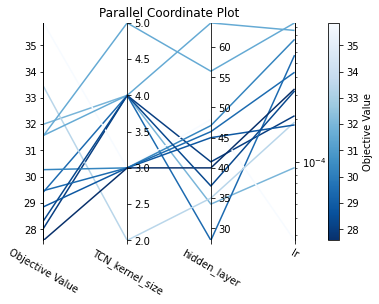

In [30]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_layer", "TCN_kernel_size", "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('TCN_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
#Read the pk file
model = TCN(c_in = 9, 
            layers=4*[40],
            ks=3,
            c_out=24).cuda()

model.load_state_dict(torch.load("TCN_BO.pt"))

<All keys matched successfully>

In [32]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [33]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [34]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   181.37438474360454
R^2                :        0.929866361489452
Mean Absolute Error:        145.8862291142944
MAPE               :        0.024533022544058147


error for next 2 hour prediction
Root Mean Squared Error :   188.7023435096221
R^2                :        0.9254087710090854
Mean Absolute Error:        150.15590055045075
MAPE               :        0.025277985018660697


error for next 3 hour prediction
Root Mean Squared Error :   206.48917844727063
R^2                :        0.9127308767062055
Mean Absolute Error:        163.69422317906987
MAPE               :        0.027729036202261793


error for next 24 hour prediction
Root Mean Squared Error :   279.2172316233805
R^2                :        0.8328939111306941
Mean Absolute Error:        226.73059945496706
MAPE               :        0.0383721237213995


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


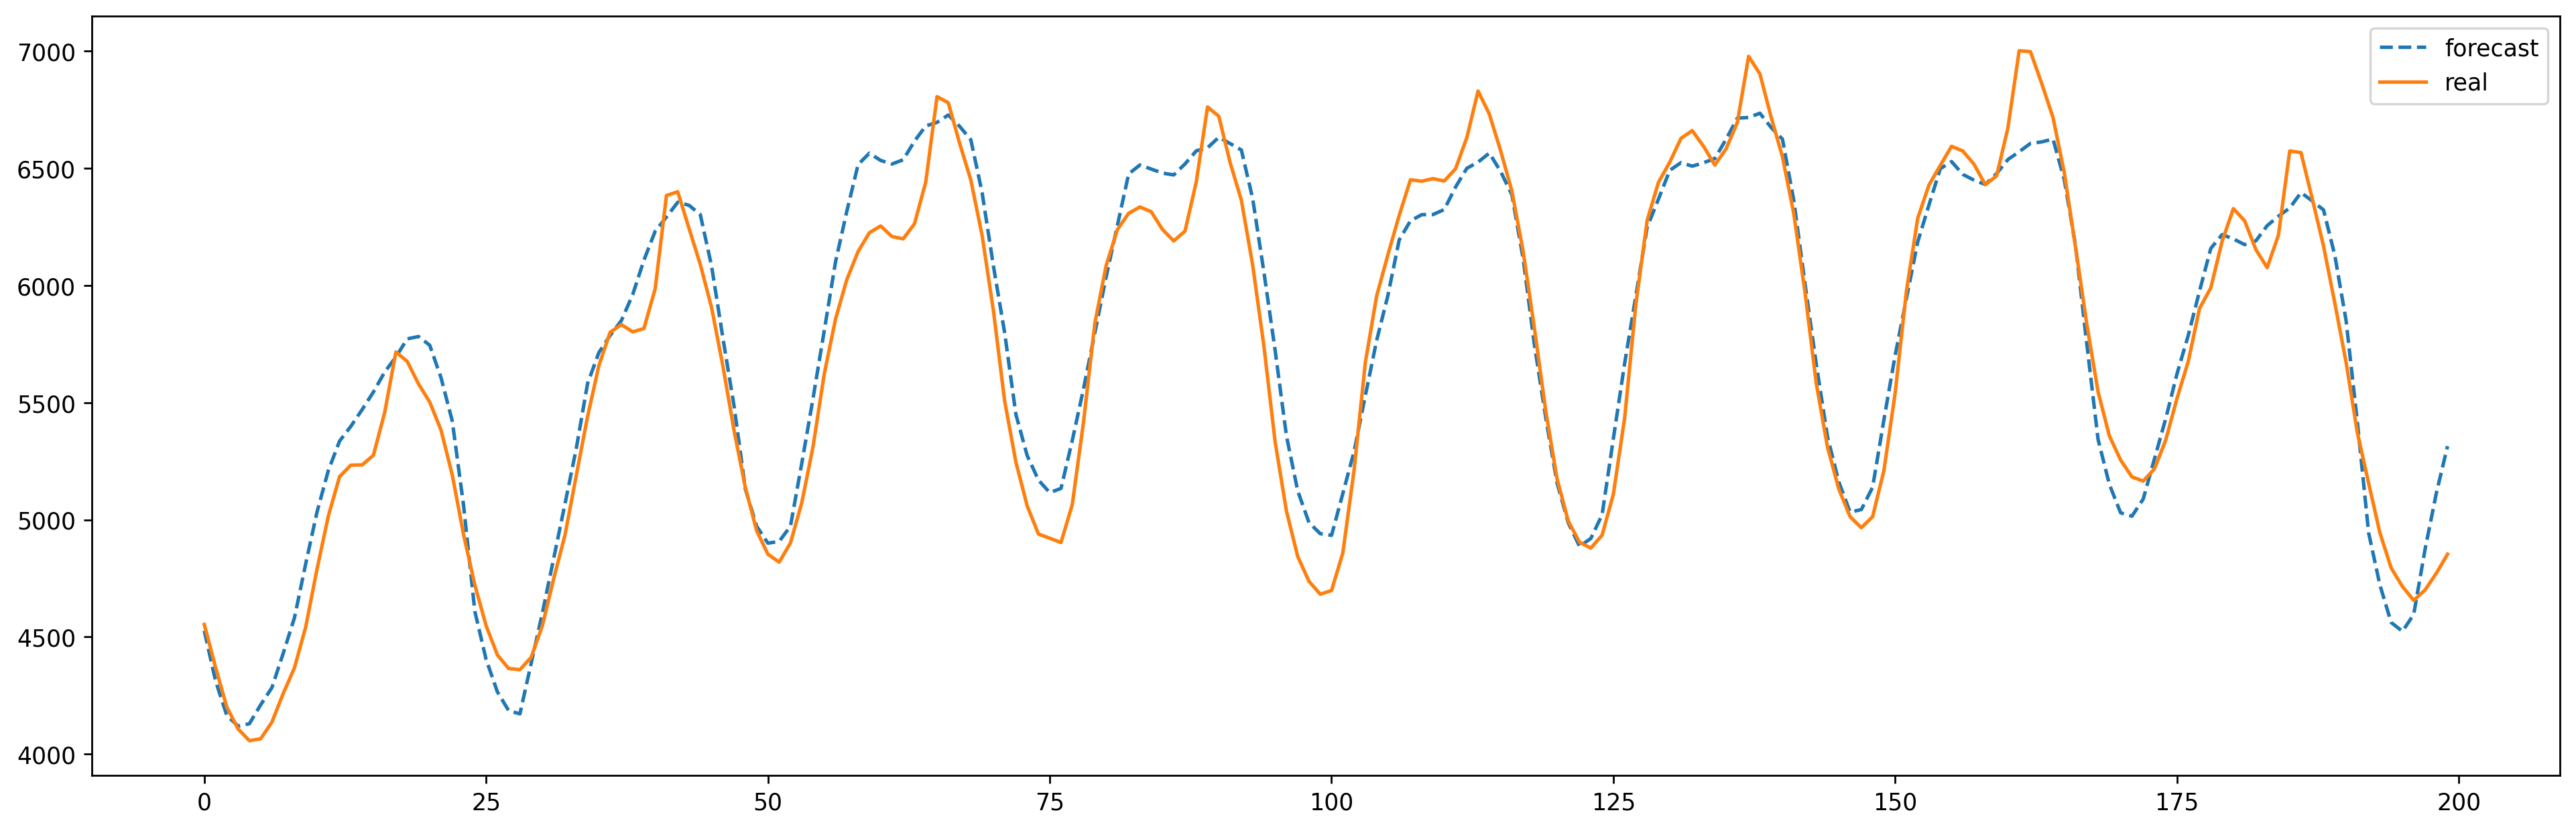

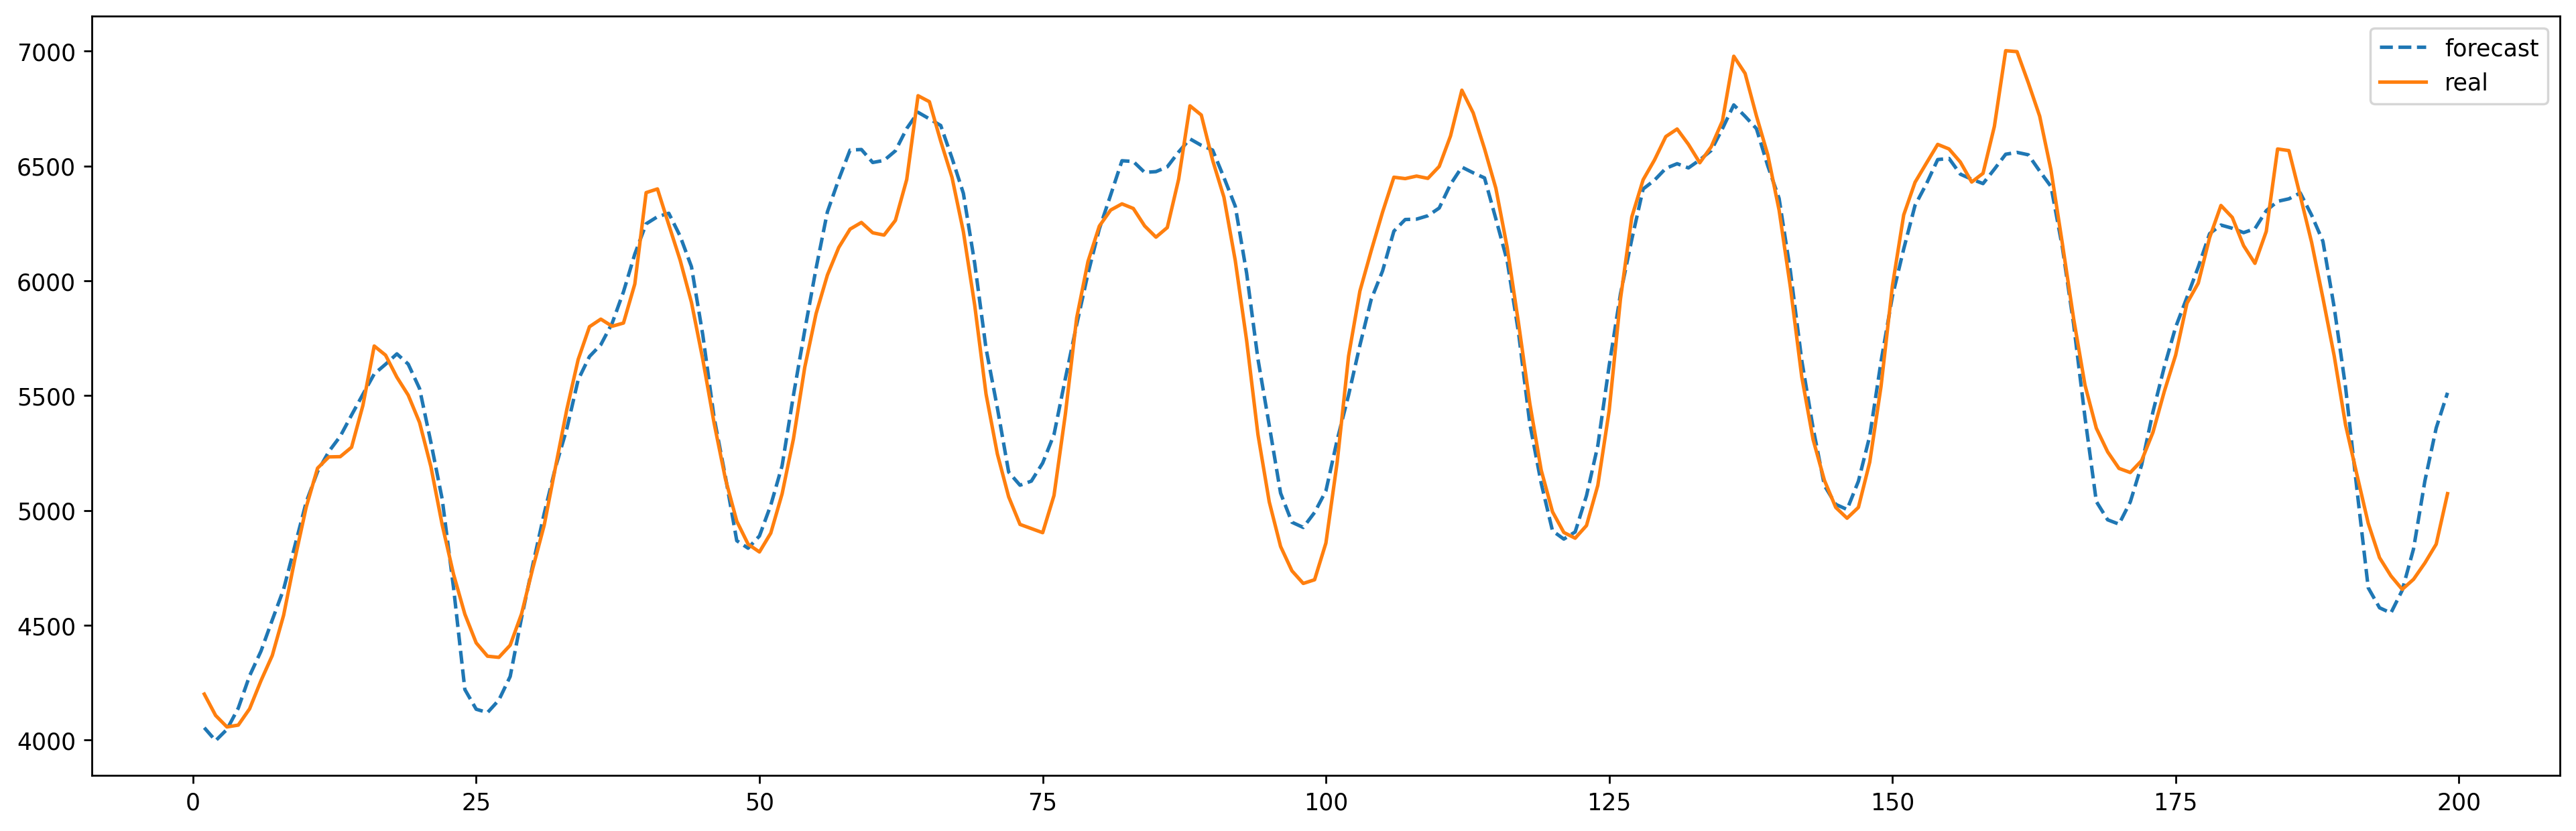

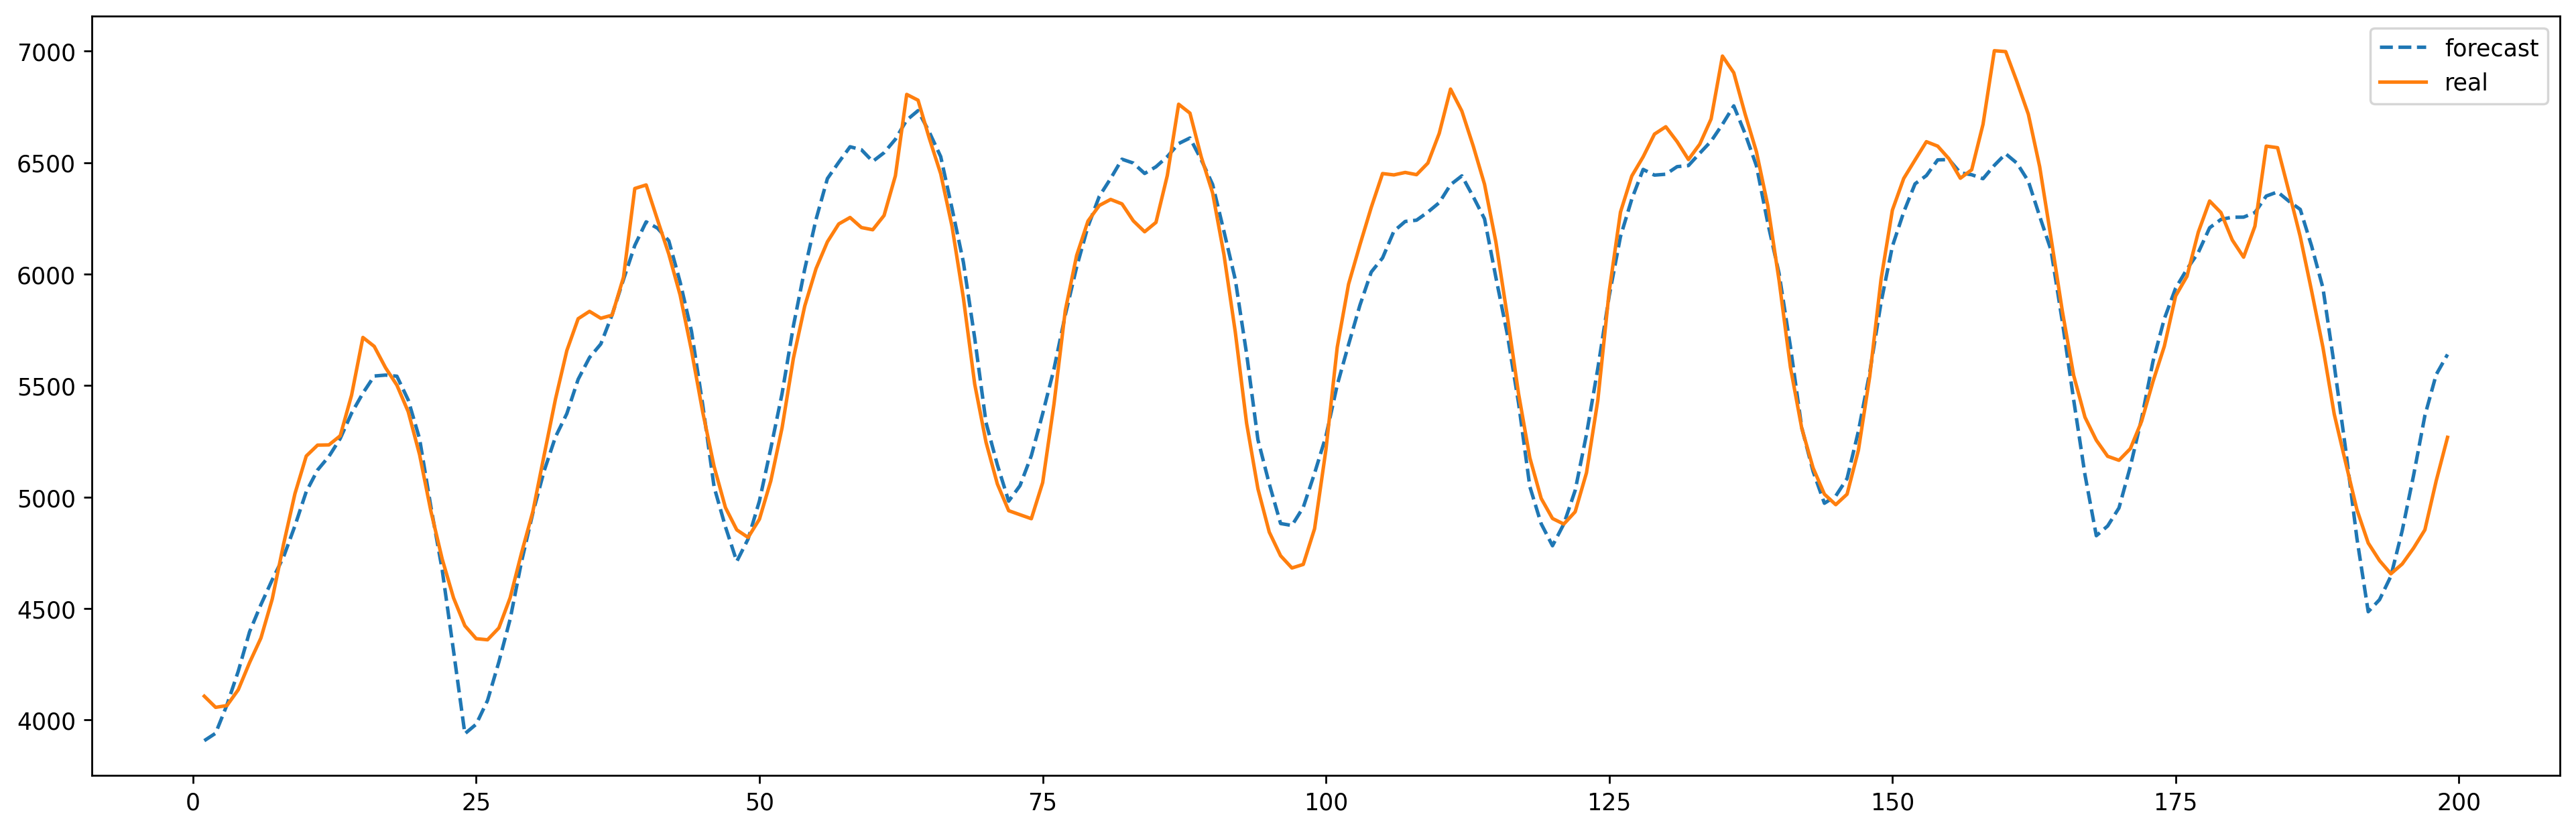

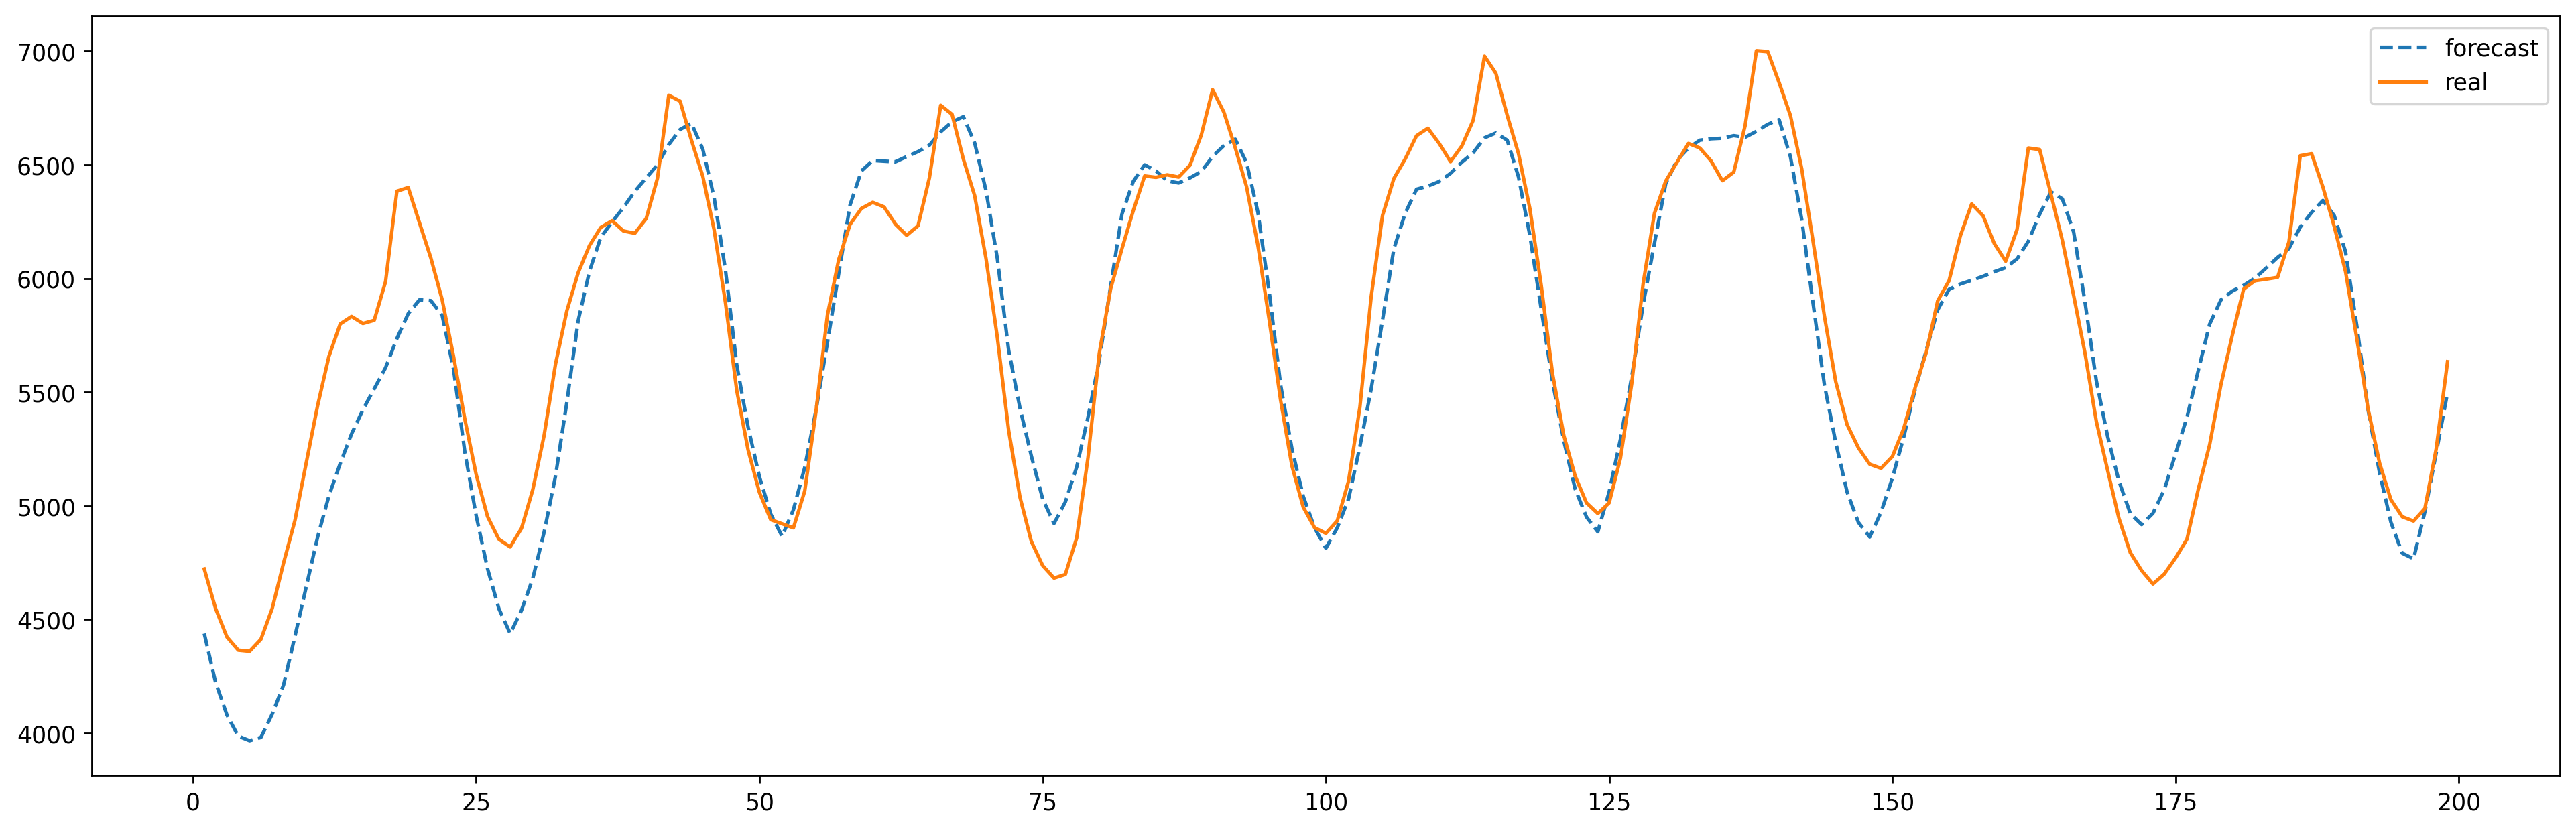

In [35]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [36]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

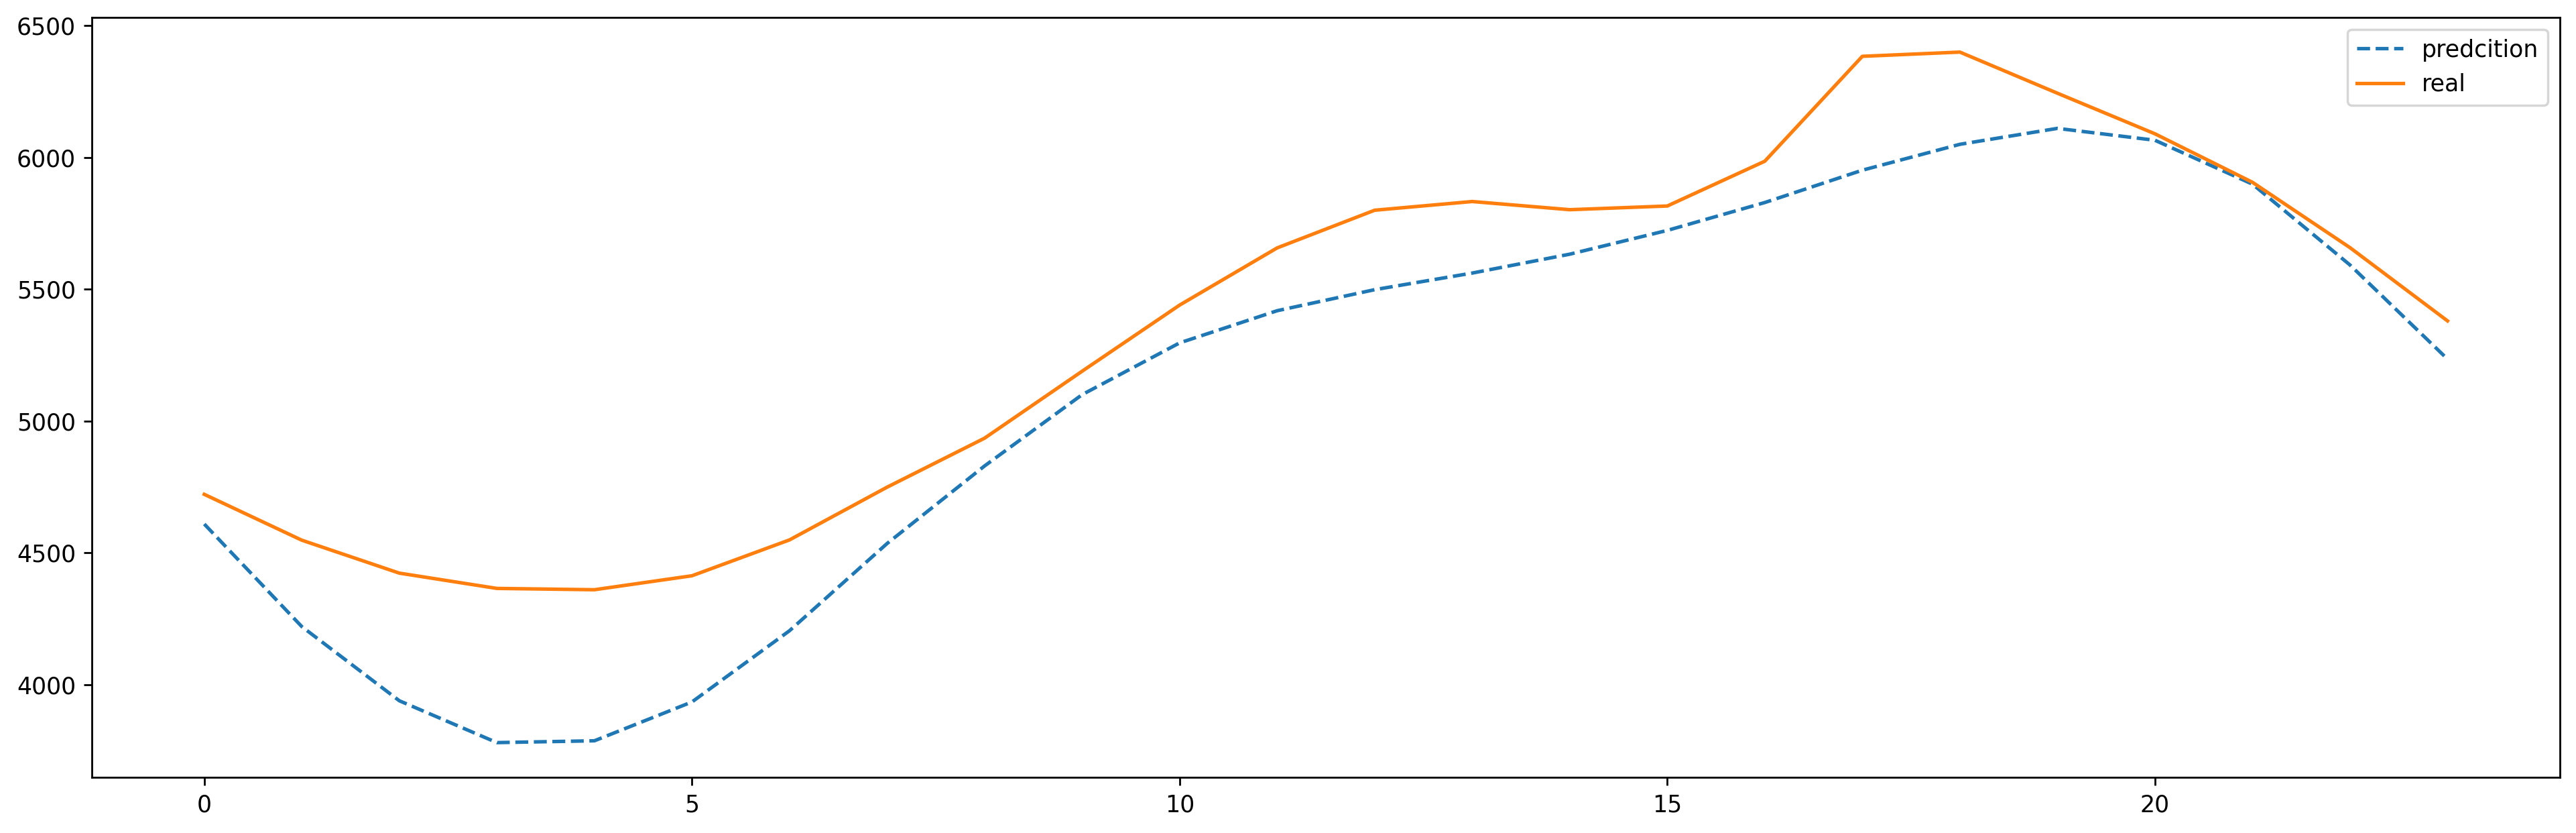

In [38]:
figure(figsize=(19, 6), dpi=250)

j=1*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
